In [1]:
import scripts.state_incentives
from scripts.eddies_functions import *
from scripts.existing_resources import *
import folium
import leafmap.foliumap as foliumap
import pandas as pd
import streamlit as st
import geopandas as gpd
from PIL import Image
from folium.plugins import Draw
from streamlit_folium import st_folium

In [2]:
data = pd.read_csv('../data/Power_Plants.csv')
resources = ['Hydroelectric', 'Solar', 'Wind']

# Import df of state renewable energy goals (% from renewable sources)
state_goals = pd.read_csv('../data/state_renewable_goals_2021.csv')
# Import df of solar & wind potential
sw_data = pd.read_csv('../data/project_data_3.csv')
sw_data['solar_sum'] = sw_data[['util_pv_te', 'resid_pv_t', 'com_pv_tec']].astype(float).sum(1)

# Import historical renewable energy data and make dataframes
historical_gen_billion_Btu = pd.read_csv('../data/historical_renewable_energy_production_by_state_in_billion_Btu.csv')
# Imoport total energy production by state (including renewables and fossil fuels)
historical_total_billion_Btu = pd.read_csv('../data/historical_total_energy_production_by_state_in_billion_Btu.csv')
# Import statewide solar power generation data (1989 - 2020) for forecasting
solar_gen = pd.read_csv('../data/solar_production.csv')
# keep years column for conversion from billion Btu to GWh
years_before_forecast = solar_gen['year']
# Import statewide wind power generation data (1989 - 2020) for forecasting
wind_gen = pd.read_csv('../data/wind_production.csv')
# Import statewide hydropower generation data (1989 - 2020) for forecasting
hydro_gen = pd.read_csv('../data/hydro_production.csv')
# Import statewide geothermal power generation data (1989 - 2020) for forecasting
geothermal_gen = pd.read_csv('../data/geothermal_production.csv')
# Import data for all other types of primary power generation data (1989 - 2020) for forecasting
coal_gen = pd.read_csv('../data/coal_production.csv')
oil_gen = pd.read_csv('../data/crude_oil_production.csv')
nat_gas_gen = pd.read_csv('../data/natural_gas_production.csv')
wood_and_waste_gen = pd.read_csv('../data/wood_and_waste_production.csv')
nuclear_gen = pd.read_csv('../data/nuclear_consumption.csv')
biomass_for_biofuels_gen = pd.read_csv('../data/biomass_for_biofuels.csv')

# convert all columns (except year) from billion Btu to GWh
historical_gen = historical_gen_billion_Btu.drop('year', axis=1) * (1.0 / 3.412)
historical_total = historical_total_billion_Btu.drop('year', axis=1) * (1.0 / 3.412)
solar_gen = solar_gen.drop('year', axis=1) * (1.0 / 3.412)
wind_gen = wind_gen.drop('year', axis=1) * (1.0 / 3.412)
hydro_gen = hydro_gen.drop('year', axis=1) * (1.0 / 3.412)
geothermal_gen = geothermal_gen.drop('year', axis=1) * (1.0 / 3.412)
coal_gen = coal_gen.drop('year', axis=1) * (1.0 / 3.412)
oil_gen = oil_gen.drop('year', axis=1) * (1.0 / 3.412)
nat_gas_gen = nat_gas_gen.drop('year', axis=1) * (1.0 / 3.412)
wood_and_waste_gen = wood_and_waste_gen.drop('year', axis=1) * (1.0 / 3.412)
nuclear_gen = nuclear_gen.drop('year', axis=1) * (1.0 / 3.412)
biomass_for_biofuels_gen = biomass_for_biofuels_gen.drop('year', axis=1) * (1.0 / 3.412)

# Calclate fraction of energy generated by renewables and put it in a new dataframe.
renewable_energy_fraction = pd.DataFrame()  # new dataframe
for state_name in list(historical_gen):
    renewable_energy_fraction[state_name] = 100.0 * historical_gen[state_name] / historical_total[state_name]

# Add back the year column
historical_gen['year'] = historical_gen_billion_Btu['year']  # Now we can start plotting.
historical_total['year'] = historical_total_billion_Btu['year']
renewable_energy_fraction['year'] = historical_total_billion_Btu['year']
solar_gen['year'] = years_before_forecast
wind_gen['year'] = years_before_forecast
hydro_gen['year'] = years_before_forecast
geothermal_gen['year'] = years_before_forecast
coal_gen['year'] = years_before_forecast
oil_gen['year'] = years_before_forecast
nat_gas_gen['year'] = years_before_forecast
wood_and_waste_gen['year'] = years_before_forecast
nuclear_gen['year'] = years_before_forecast
biomass_for_biofuels_gen['year'] = years_before_forecast

original_title = '<h1 style=color:green>The Green Solution</h1>'

countries = ['USA']

with open('../data/states.txt', 'r') as f:
    lines = f.readlines()

states = {}
statesBounding = {}
for line in lines:
    state_data = line.strip().split(': ')
    abbr, name = state_data[0], state_data[1].split(':')[0]
    values = [float(x) for x in state_data[2][1:-1].split(', ')]
    states[abbr] = name
    statesBounding[abbr] = values

# Construct a dictionary of calculated wind and solar potential for each state:
state_potential_dict = {}
for my_state in states.keys():  # Make dictionary of wind and solar potential values for each state. In the final version these will be calculated in a function from geodata.
    state_potential_dict[my_state] = {'wind_potential': max(historical_gen[my_state]) * 2,
                                      'solar_potential': max(historical_gen[my_state]) * 3}

energytype = ['Wind', 'Solar', 'Hydroelectric']
state_groups = data.groupby(['StateName', 'PrimSource'])
state_dict = {}
for (state, res_type), group in state_groups:
    if state not in state_dict:
        state_dict[state] = {}
    state_dict[state][res_type] = group[['Latitude', 'Longitude']].values.tolist()
wind, water, solar = resource_locations(data)

# Make dataframe containing total solar and wind technical potential for each state.
state_sw_potential = sw_data[['state_name', 'solar_sum', 'dist_wind_']]
state_sw_potential = state_sw_potential.groupby('state_name', as_index=False).sum()
# divide by 1000 to change units from MWh to GWh
state_sw_potential['solar_sum'] = state_sw_potential['solar_sum'] / 1000.0
state_sw_potential['dist_wind_'] = state_sw_potential['dist_wind_'] / 1000.0
# rename columns to add units
state_sw_potential.rename(columns={'solar_sum': 'solar_sum (GWh)', 'dist_wind_': 'dist_wind_ (GWh)'}, inplace=True)
# swap states keys and values so that full names in state_sw_potential can be abreviated.
states_abrv_dict = dict((v, k) for k, v in states.items())
state_sw_potential['state_name'] = state_sw_potential['state_name'].map(states_abrv_dict)

state = 'AK'

In [3]:
list(state_sw_potential['solar_sum (GWh)'][state_sw_potential['state_name'] == state])

[0.0]

C:\Users\Darren\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Darren\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Darren\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Darren\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


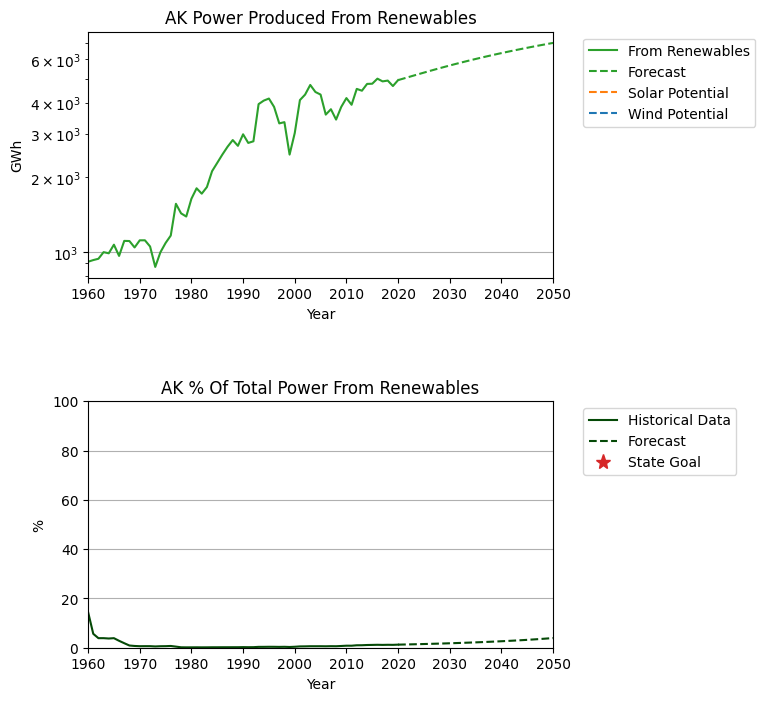

In [4]:

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from mpld3 import plugins
import streamlit.components.v1 as components

# Redefine dataframes to be plotted each time a new state is selected
future_years = list(range(2020, 2051))
hgf_df = pd.DataFrame({
    'year': future_years,
    'Predicted Renewable Generation': renewable_forecast(state, historical_gen, solar_gen, wind_gen, hydro_gen,
                                                         geothermal_gen)})
if len(list(state_sw_potential['solar_sum (GWh)'][state_sw_potential['state_name'] == state]))==0:
    list(state_sw_potential['solar_sum (GWh)'][state_sw_potential['state_name'] == state]).append(0)
sp_df = pd.DataFrame({
    'Solar Potential': list(state_sw_potential['solar_sum (GWh)'][state_sw_potential['state_name'] == state]) * len(
        list(range(1960, 2051))),
    'year': list(range(1960, 2051))})
wp_df = pd.DataFrame({
    'Wind Potential': list(state_sw_potential['dist_wind_ (GWh)'][state_sw_potential['state_name'] == state]) * len(
        list(range(1960, 2051))),
    'year': list(range(1960, 2051))})
pred_percent_df = pd.DataFrame({
    'year': future_years,
    'Predicted Percent Power From Renewables': 100.0 * renewable_fraction_forecast(state, renewable_energy_fraction,
                                                                                   coal_gen, oil_gen, nat_gas_gen,
                                                                                   wood_and_waste_gen, nuclear_gen,
                                                                                   biomass_for_biofuels_gen,
                                                                                   renewable_forecast(state,
                                                                                                      historical_gen,
                                                                                                      solar_gen,
                                                                                                      wind_gen,
                                                                                                      hydro_gen,
                                                                                                      geothermal_gen))})
state_goals_df = get_renewable_goals(state, state_goals)

two_subplot_fig = plt.figure(figsize=(6, 8))
two_subplot_fig.tight_layout()
# two_subplot_fig.add_axes([0.1, 0.1, 0.6, 0.75])

plt.subplot(211)
plt.subplots_adjust(hspace=0.5)
plt.plot(historical_gen['year'], historical_gen[state], color='tab:green', label="From Renewables")
plt.plot(hgf_df['year'], hgf_df['Predicted Renewable Generation'], color='tab:green', linestyle='dashed',
         label="Forecast")
plt.plot(sp_df['year'], sp_df['Solar Potential'], color='tab:orange', linestyle='dashed', label="Solar Potential")
plt.plot(wp_df['year'], wp_df['Wind Potential'], color='tab:blue', linestyle='dashed', label="Wind Potential")
# plt.plot(t2, f(t2), color='black', marker='.')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(state + " Power Produced From Renewables")
plt.xlabel("Year")
plt.xlim([1960, 2050])
plt.ylabel("GWh")
plt.yscale('log')
plt.grid(axis='y')

plt.subplot(212)
plt.subplots_adjust(hspace=0.5)
#plt.plot(t2, np.cos(2*np.pi*t2), color='tab:orange', linestyle='--', marker='.')
plt.ylim(0, 100)  # fix y axis range from 0 to 100 %
plt.plot(renewable_energy_fraction['year'], renewable_energy_fraction[state], color='#054907', label="Historical Data")
plt.plot(pred_percent_df['year'], pred_percent_df['Predicted Percent Power From Renewables'], color='#054907',
         linestyle='dashed', label="Forecast")
plt.plot(state_goals_df['year'], state_goals_df['goal'], '*', color='tab:red', markersize=11, label="State Goal")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(state + " % Of Total Power From Renewables")
plt.xlabel("Year")
plt.xlim([1960, 2050])
plt.ylabel("%")
plt.grid(axis='y')

plt.show()